# Analyze the output files from ReadFish

Adapt the file paths accordingly.

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from simreaduntil.shared_utils.nanosim_parsing import NanoSimId


## Check whether ReadFish is mapping the reads correctly by parsing the NanoSim id

In [3]:
mapping_paf_file = "runs/enrich_usecase/full_run_sampler_per_window/simulator_run/mapping.paf"
df = pd.read_csv(mapping_paf_file, sep="\t", header=None, usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8], names=["read_id", "read_length", "read_start", "read_end", "strand", "contig_name", "contig_length", "contig_start", "contig_end"])
df.head()

,read_id,read_length,read_start,read_end,strand,contig_name,contig_length,contig_start,contig_end
0,chr1_818237_aligned_2_R_0_5720_0,600,0,600,-,chr1,1000000,823357,823957
1,chr1_763753_aligned_21_R_0_8206_0,800,0,800,-,chr1,1000000,771159,771959
2,chr1_541945_aligned_25_R_0_5739_0,600,0,600,-,chr1,1000000,547084,547684
3,chr1_737931_aligned_46_F_0_8456_0,800,0,800,+,chr1,1000000,737931,738731
4,chr1_826073_aligned_166_R_0_6358_0,600,0,600,-,chr1,1000000,831831,832431


In [4]:
df["chrom"] = df["read_id"].apply(lambda read_id: NanoSimId.from_str(read_id).chrom)
df["mapping_correct"] = df["chrom"] == df["contig_name"]
df.head()

,read_id,read_length,read_start,read_end,strand,contig_name,contig_length,contig_start,contig_end,chrom,mapping_correct
0,chr1_818237_aligned_2_R_0_5720_0,600,0,600,-,chr1,1000000,823357,823957,chr1,True
1,chr1_763753_aligned_21_R_0_8206_0,800,0,800,-,chr1,1000000,771159,771959,chr1,True
2,chr1_541945_aligned_25_R_0_5739_0,600,0,600,-,chr1,1000000,547084,547684,chr1,True
3,chr1_737931_aligned_46_F_0_8456_0,800,0,800,+,chr1,1000000,737931,738731,chr1,True
4,chr1_826073_aligned_166_R_0_6358_0,600,0,600,-,chr1,1000000,831831,832431,chr1,True


In [5]:
fraction_correct = sum(df["mapping_correct"]) / len(df)
fraction_correct

0.999574612897737

Text(0, 0.5, 'Cumulative mapping correct')

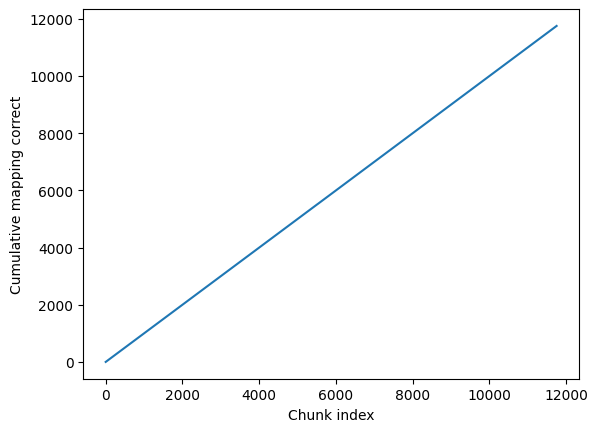

In [6]:
df["chunk_idx"] = np.arange(len(df))
df["cum_mapping_correct"] = df["mapping_correct"].cumsum()
fig, ax = plt.subplots()
sns.lineplot(data=df, x="chunk_idx", y="cum_mapping_correct", ax=ax)
ax.set_xlabel("Chunk index")
ax.set_ylabel("Cumulative mapping correct")

## Analyze chunk log

We take the last decision for each read.

In [12]:
chunk_log = "runs/enrich_usecase/full_run_sampler_per_window/simulator_run/chunk_log.txt"
chunk_df = pd.read_csv(chunk_log, sep="\t")
first_time = chunk_df["start_analysis"].min()
chunk_df["start_analysis"] -= first_time
chunk_df["end_analysis"] -= first_time
chunk_df["timestamp"] -= chunk_df["timestamp"].min() # different timer implementation
# last decision per read_id

chunk_df.head()

,client_iteration,read_in_loop,read_id,channel,read_number,seq_len,counter,mode,decision,condition,min_threshold,count_threshold,start_analysis,end_analysis,timestamp
0,2,1,chr1_818237_aligned_2_R_0_5720_0,15,chr1_818237_aligned_2_R_0_5720_0,600,1,single_on,stop_receiving,enrich_chr_1,False,False,0.000000,0.000218,0.000000
1,2,2,chr1_763753_aligned_21_R_0_8206_0,78,chr1_763753_aligned_21_R_0_8206_0,800,1,single_on,stop_receiving,enrich_chr_1,False,False,0.008041,0.008245,0.008028
2,2,3,chr1_541945_aligned_25_R_0_5739_0,86,chr1_541945_aligned_25_R_0_5739_0,600,1,single_on,stop_receiving,enrich_chr_1,False,False,0.050249,0.050441,0.050222
3,2,4,chr1_737931_aligned_46_F_0_8456_0,191,chr1_737931_aligned_46_F_0_8456_0,800,1,single_on,stop_receiving,enrich_chr_1,False,False,0.282108,0.282311,0.282090
4,2,5,chr1_826073_aligned_166_R_0_6358_0,165,chr1_826073_aligned_166_R_0_6358_0,600,1,single_on,stop_receiving,enrich_chr_1,False,False,0.332250,0.332455,0.332234


In [13]:
# check whether some reads have contradicting decisions (except for "proceed")
df1 = chunk_df[chunk_df["decision"] != "proceed"]
nb_decisions_per_read = df1.groupby("read_id", observed=True)["decision"].nunique()
nb_decisions_per_read = nb_decisions_per_read[nb_decisions_per_read > 1]
if len(nb_decisions_per_read) > 0:
    print(f"The following reads have contradicting decisions: {nb_decisions_per_read.index.values}")

In [14]:
chunk_df.sort_values("end_analysis", inplace=True)
chunk_df = chunk_df.groupby("read_id", observed=True).last().reset_index()
chunk_df.sort_values("end_analysis", inplace=True) # order not guaranteed

chunk_df["chrom"] = chunk_df["read_id"].apply(lambda read_id: NanoSimId.from_str(read_id).chrom)
chunk_df["is_rejection"] = chunk_df["decision"].apply(lambda x: x == "unblock")
chunk_df["is_stopreceiving"] = chunk_df["decision"].apply(lambda x: x == "stop_receiving")
chunk_df["cum_nb_rejections_per_chrom"] = chunk_df.groupby("chrom", observed=True)["is_rejection"].cumsum()
chunk_df["cum_nb_stopreceiving_per_chrom"] = chunk_df.groupby("chrom", observed=True)["is_stopreceiving"].cumsum()
chunk_df.head(10000)

,read_id,client_iteration,read_in_loop,channel,read_number,seq_len,counter,mode,decision,condition,min_threshold,count_threshold,start_analysis,end_analysis,timestamp,chrom,is_rejection,is_stopreceiving,cum_nb_rejections_per_chrom,cum_nb_stopreceiving_per_chrom
4555,chr1_818237_aligned_2_R_0_5720_0,2,1,15,chr1_818237_aligned_2_R_0_5720_0,600,1,single_on,stop_receiving,enrich_chr_1,False,False,0.000000,0.000218,0.000000,chr1,False,True,0,1
4196,chr1_763753_aligned_21_R_0_8206_0,2,2,78,chr1_763753_aligned_21_R_0_8206_0,800,1,single_on,stop_receiving,enrich_chr_1,False,False,0.008041,0.008245,0.008028,chr1,False,True,0,2
2810,chr1_541945_aligned_25_R_0_5739_0,2,3,86,chr1_541945_aligned_25_R_0_5739_0,600,1,single_on,stop_receiving,enrich_chr_1,False,False,0.050249,0.050441,0.050222,chr1,False,True,0,3
4014,chr1_737931_aligned_46_F_0_8456_0,2,4,191,chr1_737931_aligned_46_F_0_8456_0,800,1,single_on,stop_receiving,enrich_chr_1,False,False,0.282108,0.282311,0.282090,chr1,False,True,0,4
4608,chr1_826073_aligned_166_R_0_6358_0,2,5,165,chr1_826073_aligned_166_R_0_6358_0,600,1,single_on,stop_receiving,enrich_chr_1,False,False,0.332250,0.332455,0.332234,chr1,False,True,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10904,chr2_948429_aligned_11335_R_0_7314_0,258,57,331,chr2_948429_aligned_11335_R_0_7314_0,5800,1,single_off,unblock,enrich_chr_1,False,False,53.131931,53.132076,53.131196,chr2,True,False,4938,3
6312,chr2_208090_aligned_11673_F_0_5703_0,258,58,476,chr2_208090_aligned_11673_F_0_5703_0,200,1,single_off,unblock,enrich_chr_1,False,False,53.132271,53.132340,53.131459,chr2,True,False,4939,3
9514,chr2_72326_aligned_11545_R_0_6764_0,258,59,461,chr2_72326_aligned_11545_R_0_6764_0,2000,1,single_off,unblock,enrich_chr_1,False,False,53.133177,53.133263,53.132383,chr2,True,False,4940,3
1240,chr1_294523_aligned_11554_F_0_9141_0,258,60,144,chr1_294523_aligned_11554_F_0_9141_0,1800,1,single_on,stop_receiving,enrich_chr_1,False,False,53.134323,53.134421,53.133541,chr1,False,True,0,5056


Text(0.5, 1.0, 'Cumulative number of stopreceiving per chromosome')

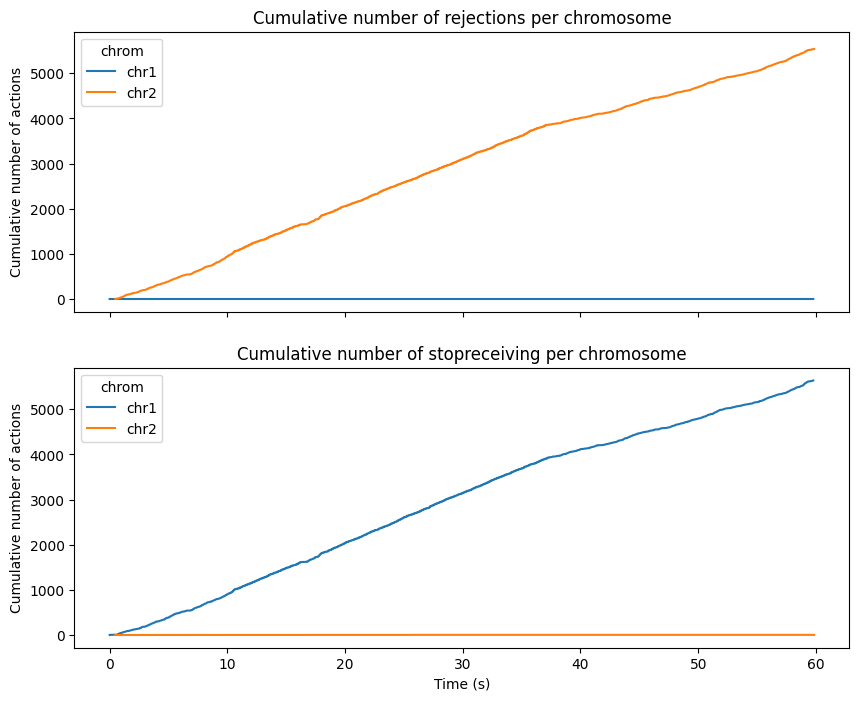

In [21]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 8), nrows=2, sharex=True, sharey=True)
sns.lineplot(data=chunk_df, x="end_analysis", y="cum_nb_rejections_per_chrom", hue="chrom", ax=ax1)
sns.lineplot(data=chunk_df, x="end_analysis", y="cum_nb_stopreceiving_per_chrom", hue="chrom", ax=ax2)
ax1.set_ylabel("Cumulative number of actions")
ax1.set_title("Cumulative number of rejections per chromosome")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Cumulative number of actions")
ax2.set_title("Cumulative number of stopreceiving per chromosome")

# on one plot, but legend not correct
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.lineplot(data=chunk_df, x="end_analysis", y="cum_nb_rejections_per_chrom", hue="chrom", ax=ax)
# sns.lineplot(data=chunk_df, x="end_analysis", y="cum_nb_stopreceiving_per_chrom", hue="chrom", ax=ax, linestyle="--", legend=False)
# ax1.set_ylabel("Cumulative number of actions")
# ax1.set_title("Cumulative number of rejections per chromosome")